Generating Training Data (SNR=7dB)...
Generating Calibration Data (H0 Only)...

--- Processing MLP_ent ---
Training Complete. Score: 0.9813
Threshold (PFA=0.0001): 0.990124


Testing MLP_ent: 100%|██████████| 21/21 [00:41<00:00,  1.99s/it]



--- Processing MLP_mse ---
Training Complete. Score: 0.7785
Threshold (PFA=0.0001): 0.718539


Testing MLP_mse: 100%|██████████| 21/21 [00:42<00:00,  2.01s/it]



--- Processing MLP_mae ---
Training Complete. Score: 0.7892
Threshold (PFA=0.0001): 0.767607


Testing MLP_mae: 100%|██████████| 21/21 [00:42<00:00,  2.01s/it]


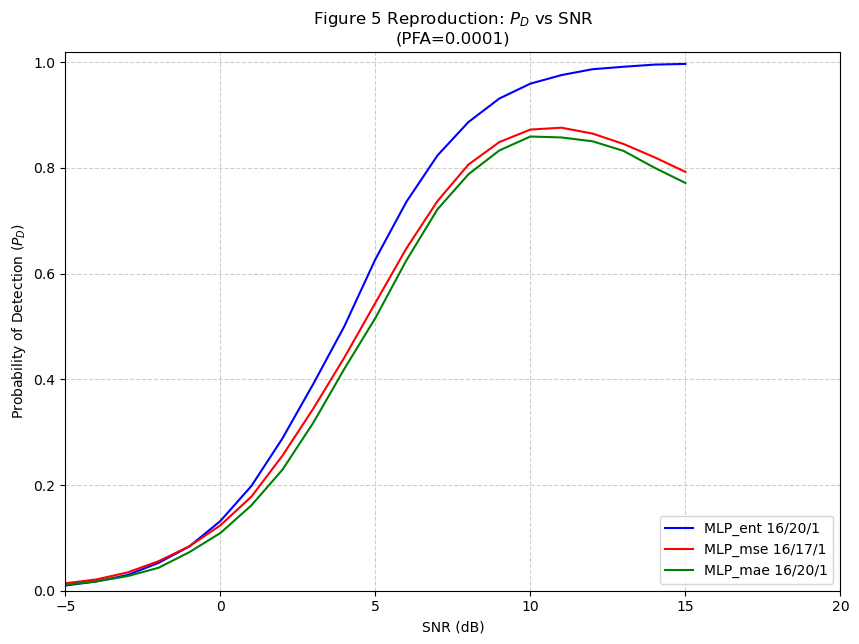


Simulation Complete.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- Configuration ---
L_complex = 8          # Number of complex echoes
L_real = 2 * L_complex # 16 real inputs

# Training Parameters
TRAIN_SNR_dB = 7       
N_TRAIN = 50_000       
PFA_TARGET = 1e-4      
N_H0_CALIBRATION = 500_000 # Reduced slightly for efficiency
N_H1_TEST = 30_000     
SNR_RANGE_dB = np.linspace(-5, 15, 21) 
noise_power = 1.0

# --- Model Configurations from Figure 5 ---
models_config = [
    {
        'name': 'MLP_ent',
        'type': 'classifier', # Cross-Entropy (Log-Loss)
        'hidden': 20,
        'color': 'blue'
    },
    {
        'name': 'MLP_mse',
        'type': 'regressor',  # Mean Squared Error
        'hidden': 17,
        'loss': 'squared_error',
        'color': 'red'
    },
    {
        'name': 'MLP_mae',
        'type': 'regressor',  # Mean Absolute Error (approximated by Huber)
        'hidden': 20,
        'loss': 'huber',      # Huber is the closest proxy for MAE in sklearn MLP
        'color': 'green'
    }
]

# --- Data Generation Functions ---

def generate_complex_gaussian(N_samples, Cov_matrix):
    L = Cov_matrix.shape[0]
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    Sigma = 0.5 * np.block([[Re_C, -Im_C], [Im_C, Re_C]])
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    return Z_complex

def complex_to_real_inputs(Z_complex):
    N, L = Z_complex.shape
    X_real = np.zeros((N, 2 * L))
    X_real[:, ::2] = Z_complex.real
    X_real[:, 1::2] = Z_complex.imag
    return X_real

def generate_dataset(N_samples, snr_db, L_complex, noise_power):
    snr_linear = 10**(snr_db / 10.0)
    signal_power = snr_linear * noise_power
    C_noise = noise_power * np.identity(L_complex)
    
    # Split
    N_H0 = N_samples // 2
    N_H1 = N_samples - N_H0

    # H0
    Z_H0 = generate_complex_gaussian(N_H0, C_noise)
    X_H0 = complex_to_real_inputs(Z_H0)
    y_H0 = np.zeros(N_H0)

    # H1 (Case 1A: Unknown correlation)
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    Z_H1 = np.zeros((N_H1, L_complex), dtype=complex)
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_signal = signal_power * R_signal
        C_total = C_signal + C_noise
        Z_H1[i, :] = generate_complex_gaussian(1, C_total).flatten()
        
    X_H1 = complex_to_real_inputs(Z_H1)
    y_H1 = np.ones(N_H1)

    X = np.vstack([X_H0, X_H1])
    y = np.concatenate([y_H0, y_H1])
    idx = np.random.permutation(len(y))
    return X[idx], y[idx]

def generate_H1_only(N_samples, snr_db, L_complex, noise_power):
    snr_linear = 10**(snr_db / 10.0)
    signal_power = snr_linear * noise_power
    C_noise = noise_power * np.identity(L_complex)
    
    rho_t_samples = np.random.uniform(0, 1, N_samples)
    Z_H1 = np.zeros((N_samples, L_complex), dtype=complex)
    
    for i in range(N_samples):
        rho_t = rho_t_samples[i]
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_signal = signal_power * R_signal
        C_total = C_signal + C_noise
        Z_H1[i, :] = generate_complex_gaussian(1, C_total).flatten()
        
    return complex_to_real_inputs(Z_H1)

def generate_H0_only(N_samples, L_complex, noise_power):
    C_noise = noise_power * np.identity(L_complex)
    Z_H0 = generate_complex_gaussian(N_samples, C_noise)
    return complex_to_real_inputs(Z_H0)

# --- Simulation Execution ---

# 1. Generate Training Data (Shared)
print(f"Generating Training Data (SNR={TRAIN_SNR_dB}dB)...")
X_train, y_train = generate_dataset(N_TRAIN, TRAIN_SNR_dB, L_complex, noise_power)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 2. Generate Calibration Data (Shared)
print("Generating Calibration Data (H0 Only)...")
X_H0_cal = generate_H0_only(N_H0_CALIBRATION, L_complex, noise_power)
X_H0_cal_scaled = scaler.transform(X_H0_cal)

results = {}

plt.figure(figsize=(10, 7))

for config in models_config:
    print(f"\n--- Processing {config['name']} ---")
    
    # A. Model Initialization
    if config['type'] == 'classifier':
        model = MLPClassifier(hidden_layer_sizes=(config['hidden'],),
                              activation='tanh', solver='adam', max_iter=300, random_state=42)
    else:
        # Regressor used for MSE and MAE (Huber)
        loss_func = config.get('loss', 'squared_error')
        model = MLPRegressor(hidden_layer_sizes=(config['hidden'],),
                             activation='tanh', solver='adam', max_iter=300, 
                            random_state=42)

    # B. Training
    model.fit(X_train_scaled, y_train)
    print(f"Training Complete. Score: {model.score(X_train_scaled, y_train):.4f}")

    # C. Threshold Calibration
    # For Classifier: Use predict_proba. For Regressor: Use predict output directly.
    if config['type'] == 'classifier':
        scores_H0 = model.predict_proba(X_H0_cal_scaled)[:, 1]
    else:
        scores_H0 = model.predict(X_H0_cal_scaled)
    
    threshold = np.percentile(scores_H0, 100 * (1 - PFA_TARGET))
    print(f"Threshold (PFA={PFA_TARGET}): {threshold:.6f}")

    # D. Testing PD vs SNR
    pd_values = []
    for snr in tqdm(SNR_RANGE_dB, desc=f"Testing {config['name']}"):
        X_H1_test = generate_H1_only(N_H1_TEST, snr, L_complex, noise_power)
        X_H1_test_scaled = scaler.transform(X_H1_test)
        
        if config['type'] == 'classifier':
            scores_H1 = model.predict_proba(X_H1_test_scaled)[:, 1]
        else:
            scores_H1 = model.predict(X_H1_test_scaled)
            
        pd = np.sum(scores_H1 > threshold) / N_H1_TEST
        pd_values.append(pd)
    
    # E. Plotting
    plt.plot(SNR_RANGE_dB, pd_values, label=f"{config['name']} {16}/{config['hidden']}/1", 
             color=config['color'], linewidth=1.5)

# --- Final Plot Adjustments ---
plt.title(f'Figure 5 Reproduction: $P_D$ vs SNR\n(PFA={PFA_TARGET})')
plt.xlabel('SNR (dB)')
plt.ylabel('Probability of Detection ($P_D$)')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.xlim(-5, 20)
plt.ylim(0, 1.02)
plt.show()

print("\nSimulation Complete.")